In [1]:
import astropy.io.fits as pf
import pylab as mplot
%pylab inline
import healpy as hp
from astropy import units as u
from astropy.coordinates import SkyCoord
from pylab import cm
mplot.rc('text', usetex=True)
mplot.rc('font', family='serif')
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)


Populating the interactive namespace from numpy and matplotlib


In [2]:
planck = pf.open('HFI_PCCS_SZ-union_R2.08.fits')
planck_data = pf.open('HFI_PCCS_SZ-union_R2.08.fits')[1].data
print(planck[1].header.keys)

<bound method Header.keys of XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  359 / length of dimension 1                          
NAXIS2  =                 1653 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   30 / number of table fields                         
EXTNAME = 'PSZ2_UNION'                                                          
TTYPE1  = 'INDEX   '                                                            
TFORM1  = 'I       '                                                            
TUNIT1  = 'None    '                                                            

In [3]:
print(planck[1].data['redmapper'])
print(planck[1].data['act'])
print(planck[1].data['spt'])
print(planck[1].data['mcxc']) # X-ray!

['RMJ151653.9-010506.3' 'RMJ133408.7+201453.0' '' ... '' '' '']
['' '' '' ... '' '' '']
['' '' '' ... 'SPT-CLJ2012-4130' '' '']
['J1516.5-0056' 'J1334.1+2013' 'J2104.3-4120' ... 'J2012.0-4129' '' '']


In [4]:
print(len(planck_data))

1653


(array([242., 243., 239., 186.,  85.,  54.,  30.,   9.,   4.,   2.]),
 array([0.011054 , 0.1071486, 0.2032432, 0.2993378, 0.3954324, 0.491527 ,
        0.5876216, 0.6837162, 0.7798108, 0.8759054, 0.972    ]),
 <a list of 10 Patch objects>)

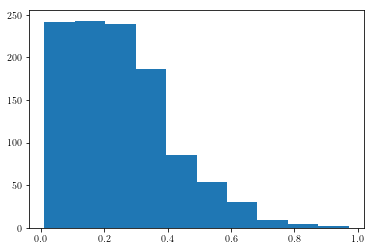

In [5]:
z = planck_data['redshift']
mplot.hist(z[z>0])

(array([872., 149.,  44.,  12.,   6.,   4.,   2.,   3.,   1.,   1.]),
 array([ 4.50093508,  8.94935269, 13.39777031, 17.84618793, 22.29460554,
        26.74302316, 31.19144077, 35.63985839, 40.088276  , 44.53669362,
        48.98511124]),
 <a list of 10 Patch objects>)

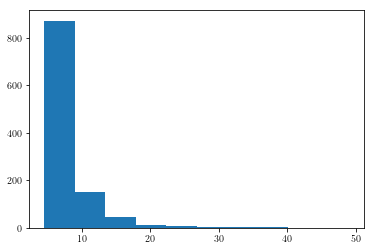

In [6]:
snr = planck_data['snr']
mass = planck_data['MSZ']

mplot.hist(snr[z>0])

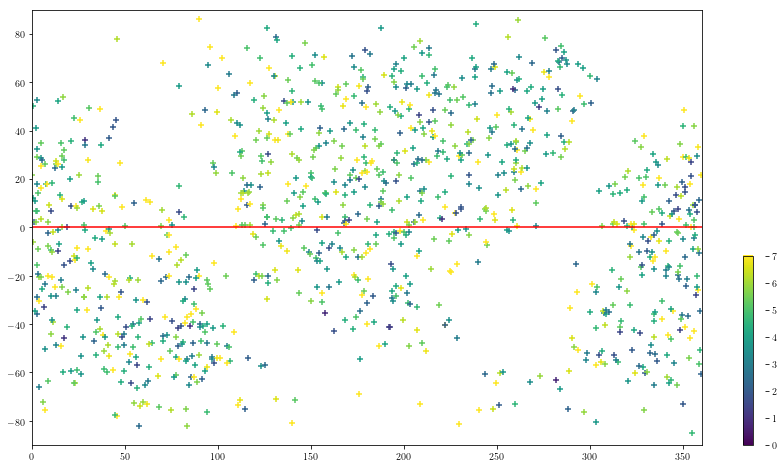

In [7]:
mplot.figure(figsize=(15,8))
ra = planck_data['ra']
dec = planck_data['dec']
lon = planck_data['glon']
lat = planck_data['glat']
mplot.scatter(ra[z>0], dec[z>0], marker='+', c=mass[z>0])
mplot.plot([0,360],[0,0], color='r')
mplot.xlim(0,360)
mplot.ylim(-90,90)
mplot.colorbar()
mplot.clim(0,7)

In [8]:
# find the 40 highest SNR clusters with 0<z<0.2
N = 40
id_snr = np.argsort(snr[(z>0)*(z<0.2)])[-1*N:][::-1]
mass_sel = mass[(z>0)*(z<0.2)][id_snr]
snr_sel = snr[(z>0)*(z<0.2)][id_snr]

RA_sel, DEC_sel = ra[(z>0)*(z<0.2)][id_snr], dec[(z>0)*(z<0.2)][id_snr]
LON_sel, LAT_sel = lon[(z>0)*(z<0.2)][id_snr], lat[(z>0)*(z<0.2)][id_snr]

Z_sel = z[(z>0)*(z<0.2)][id_snr]

In [9]:
sz_map = hp.read_map('COM_CompMap_Compton-SZMap-milca-ymaps_2048_R2.00.fits', nest=False)

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:326: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  "assume {}".format(schm))


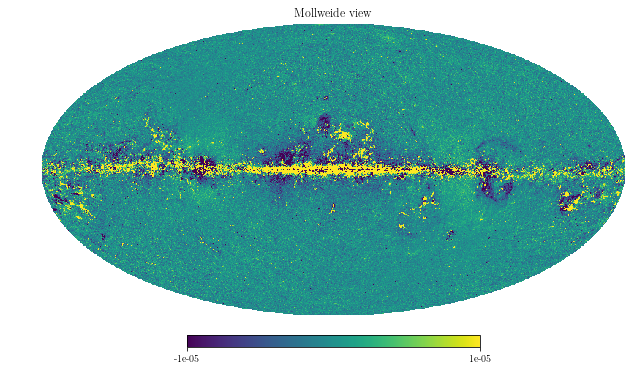

In [10]:
hp.mollview(sz_map, min=-0.00001, max=0.00001)

In [11]:
theta_p = (90.- LAT_sel)/180*np.pi
phi_p = np.array(LON_sel)/180*np.pi

In [12]:
nside = 2048
pix = np.arange(hp.nside2npix(nside))
theta, phi = hp.pix2ang(nside, pix)

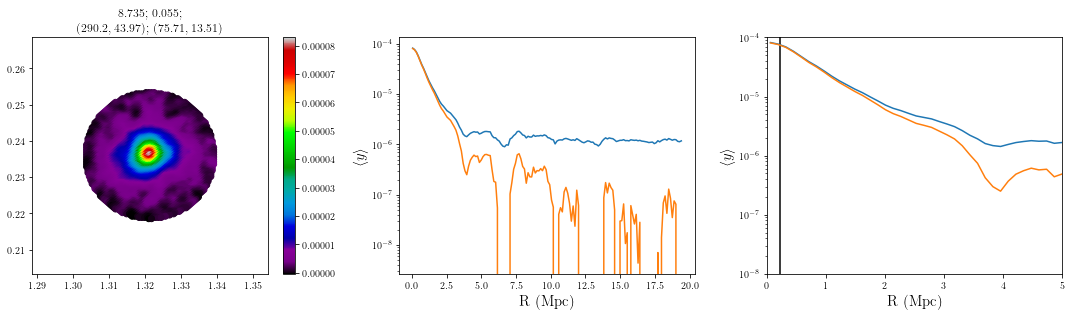

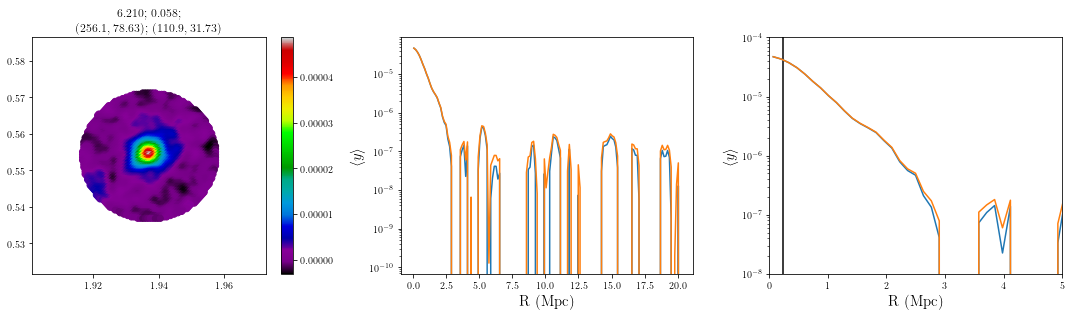

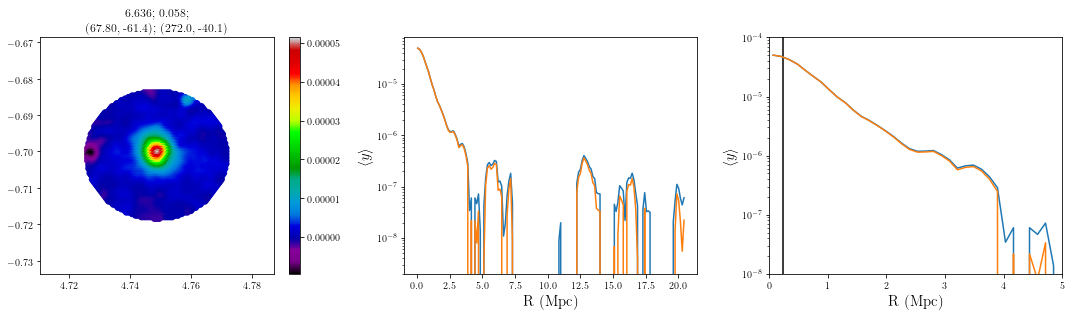

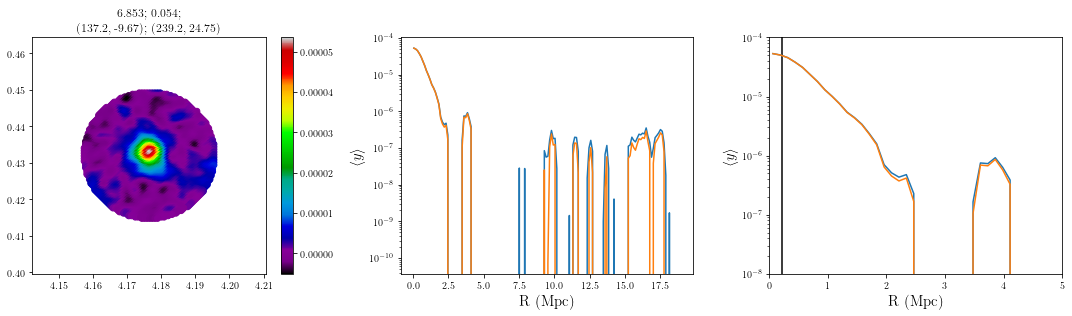

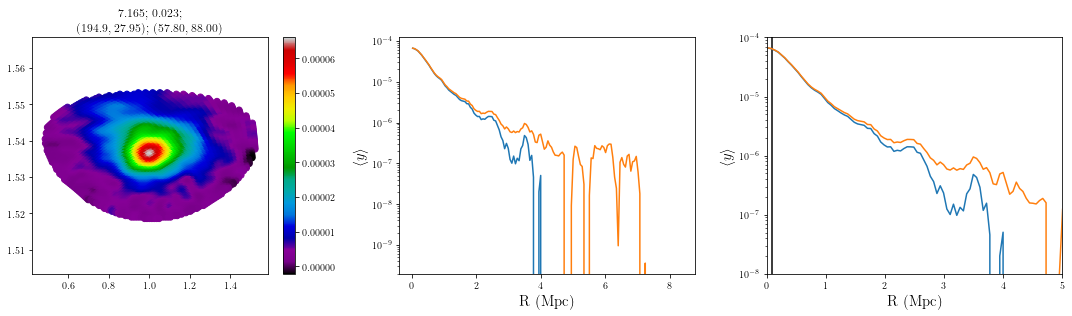

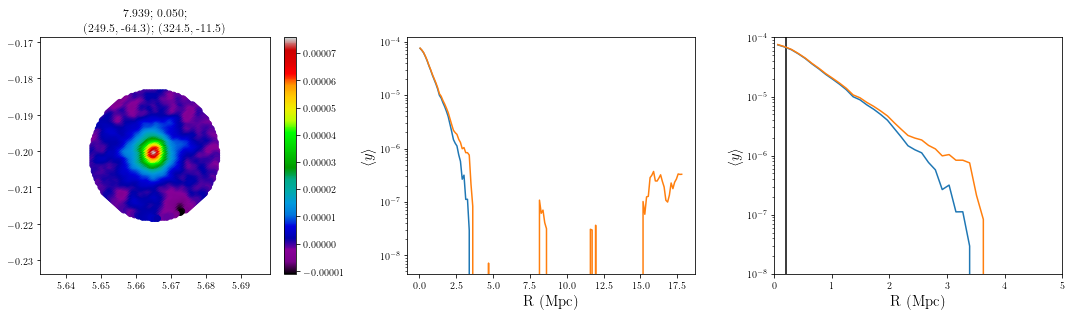

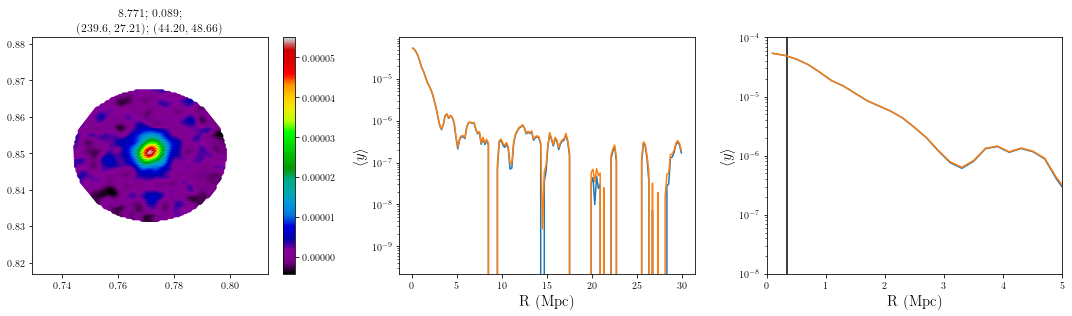

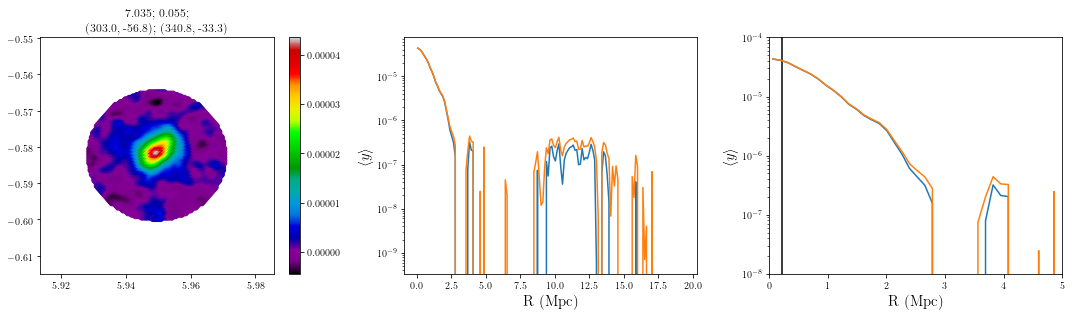

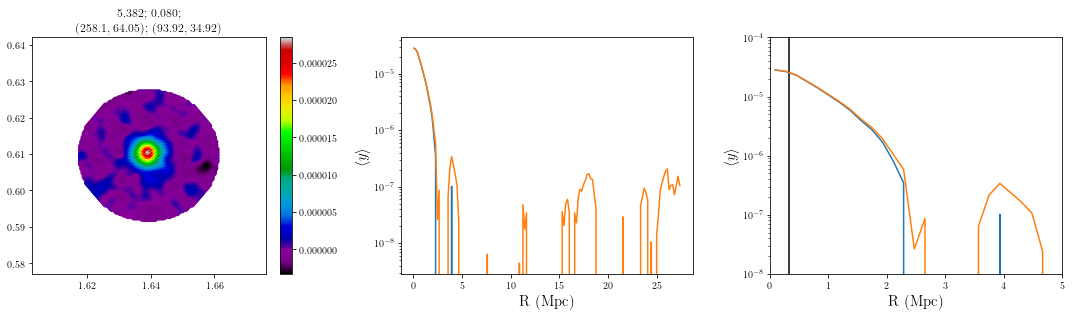

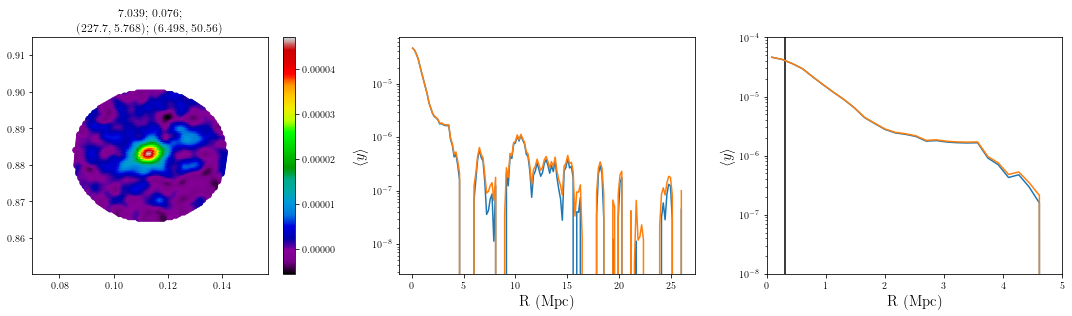

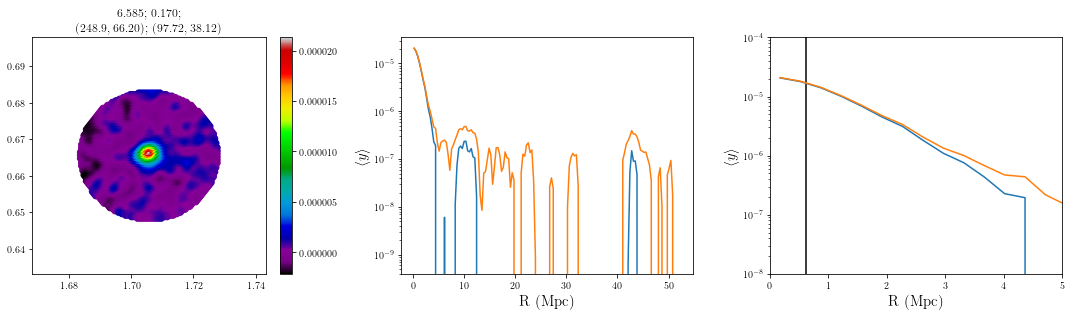

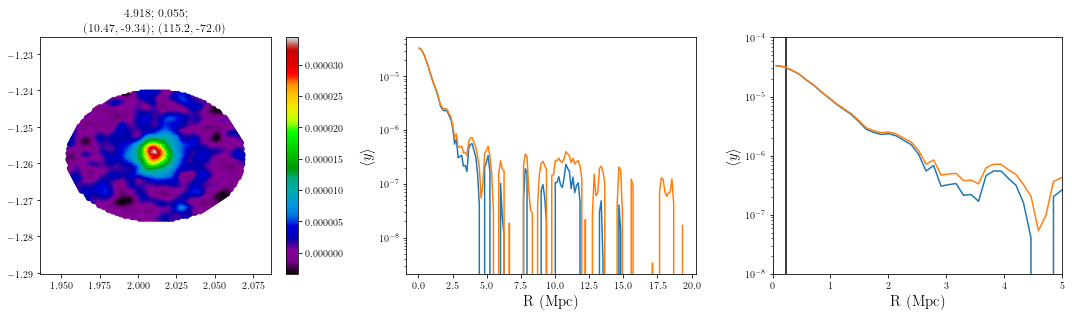

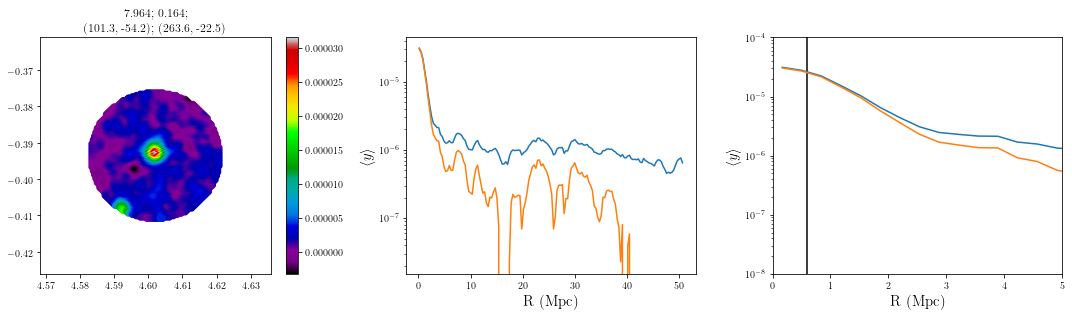

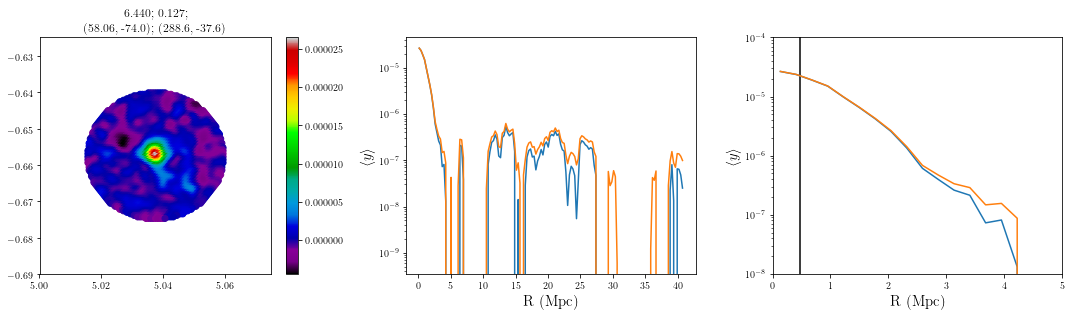

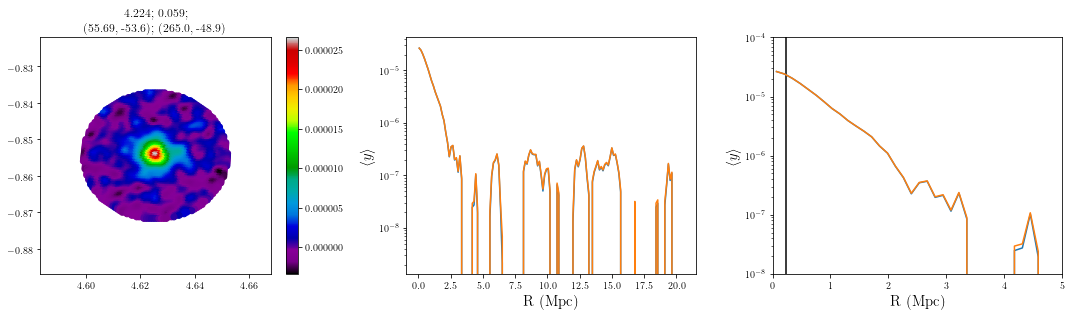

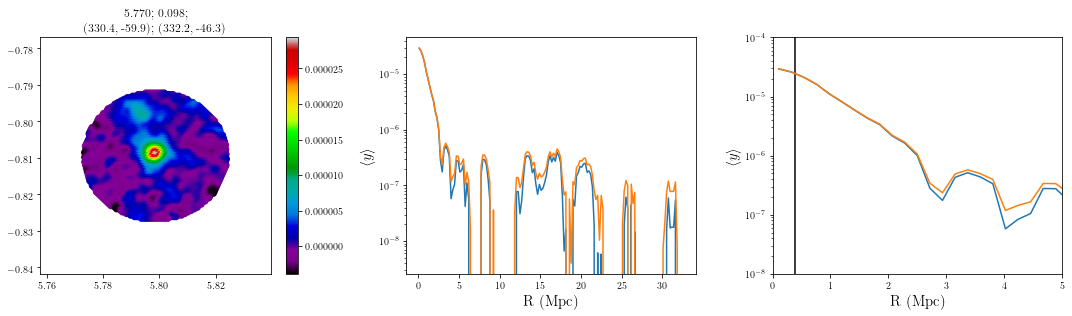

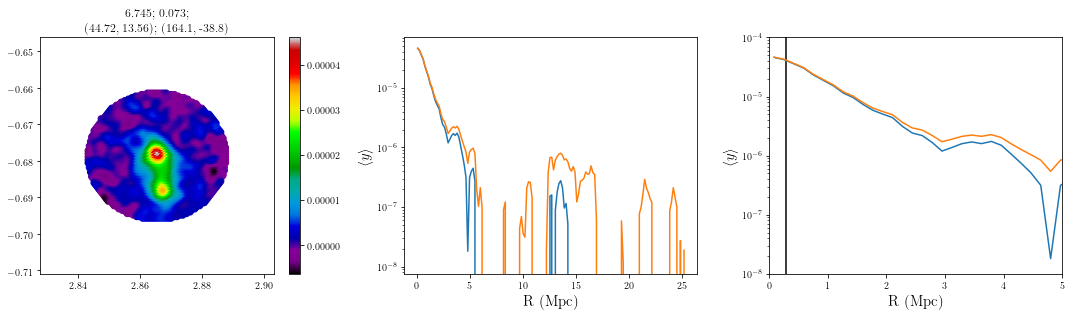

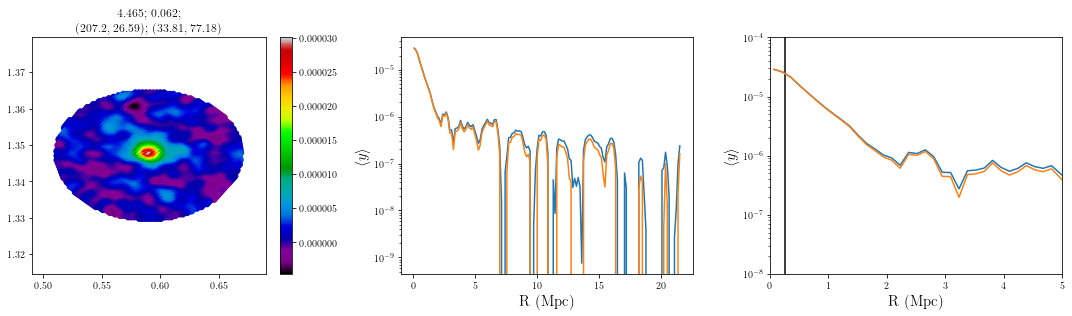

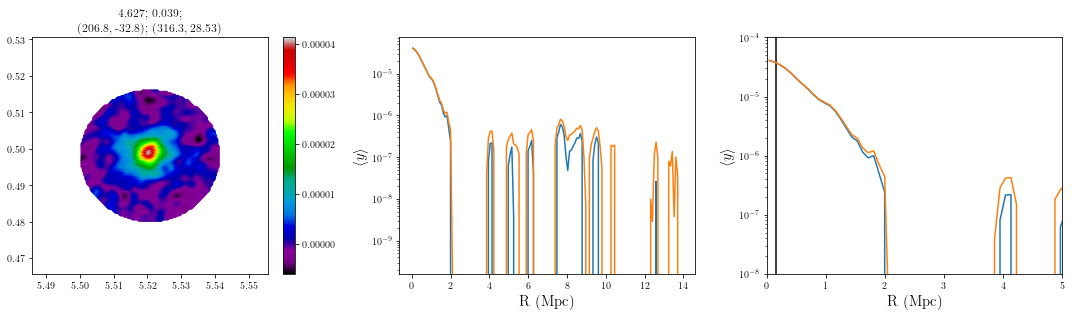

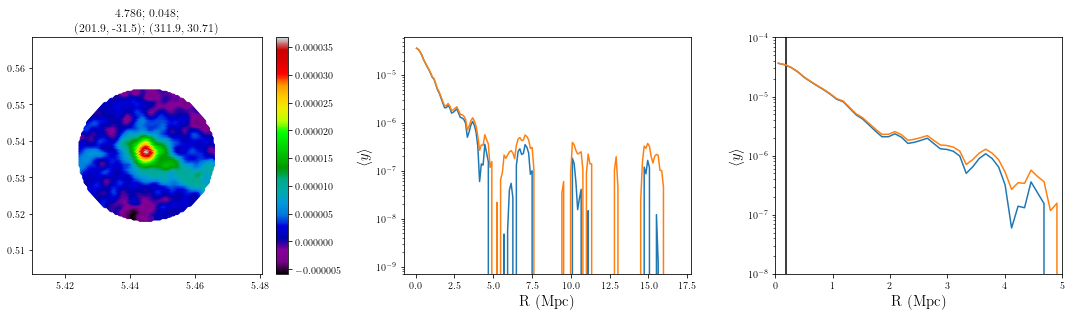

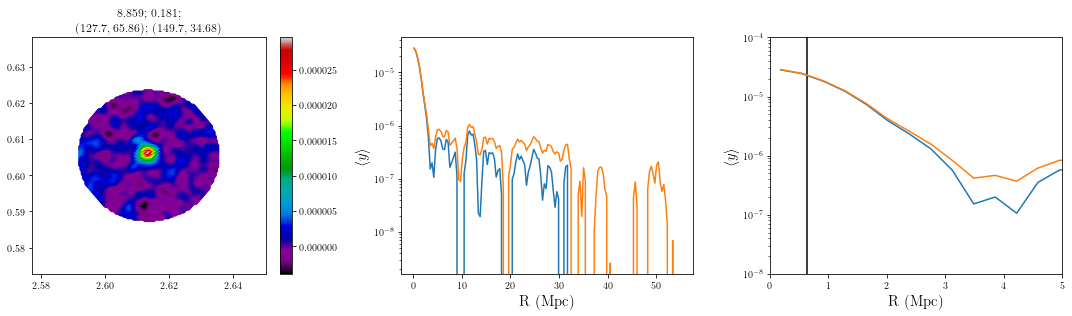

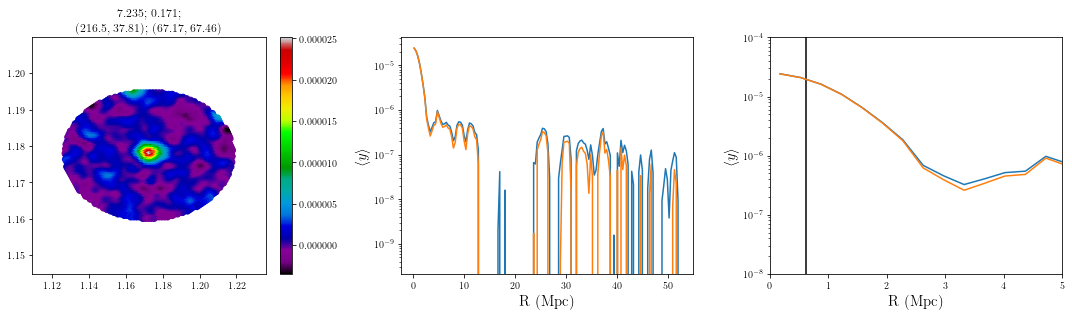

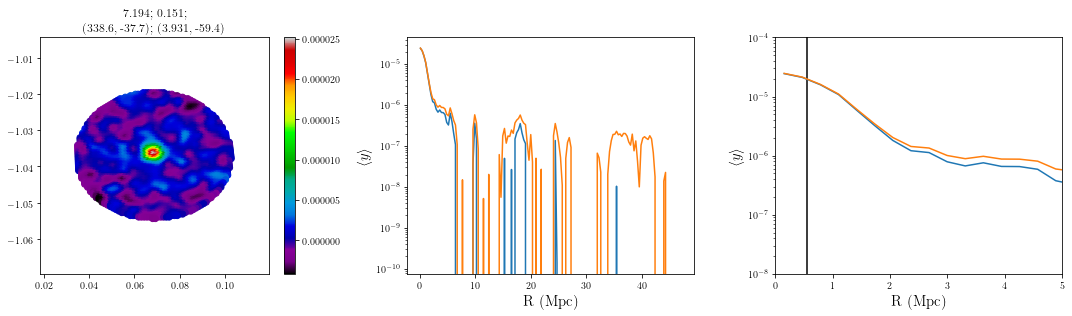

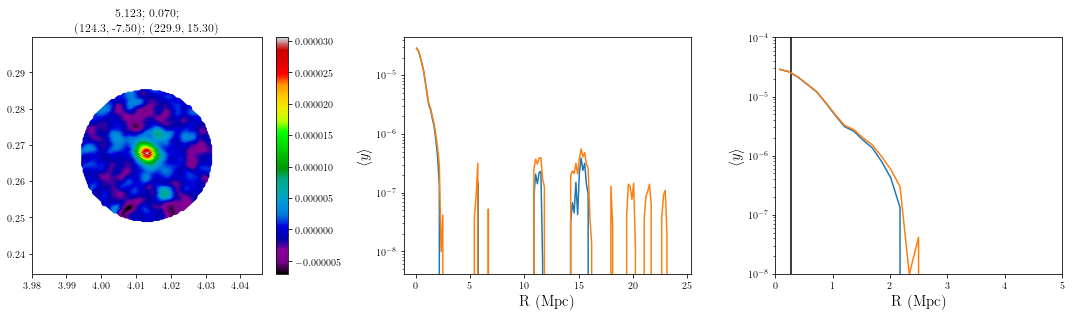

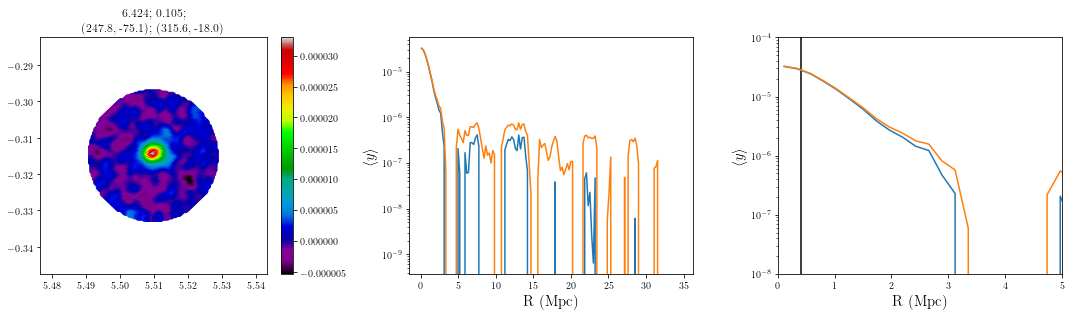

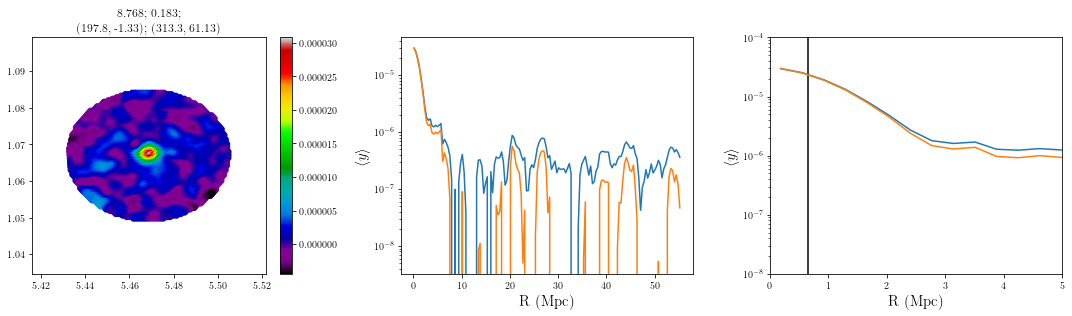

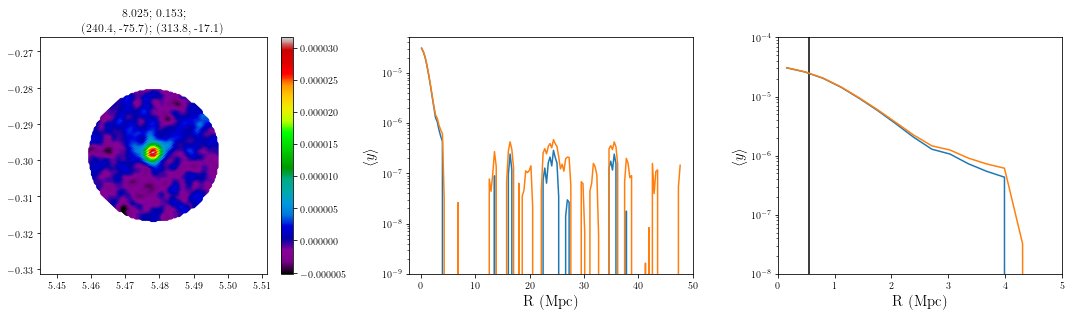

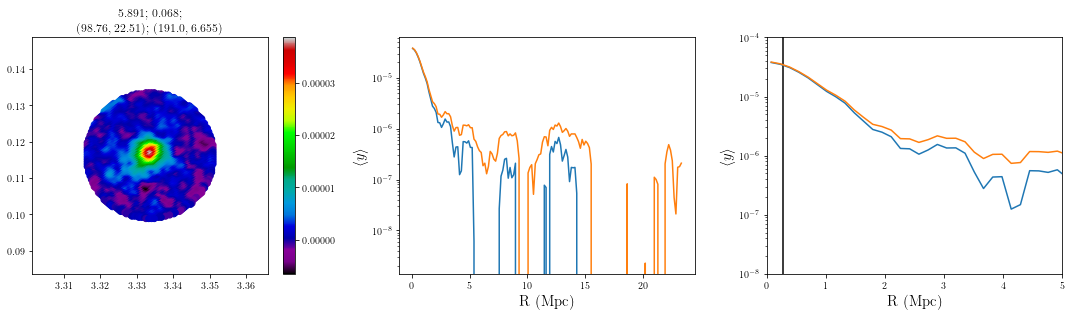

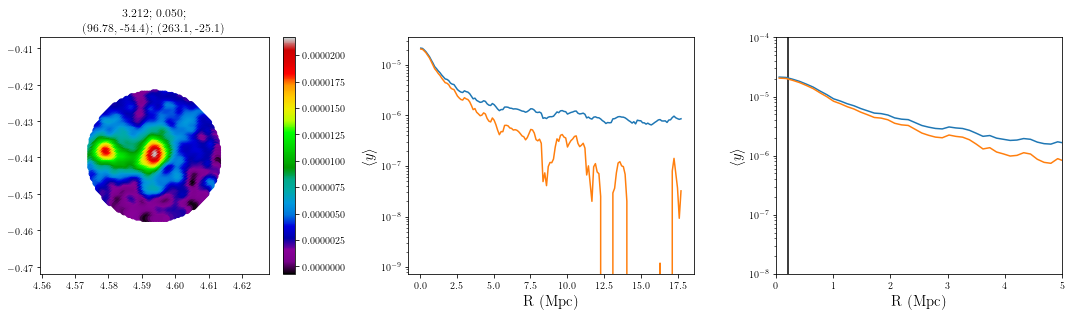

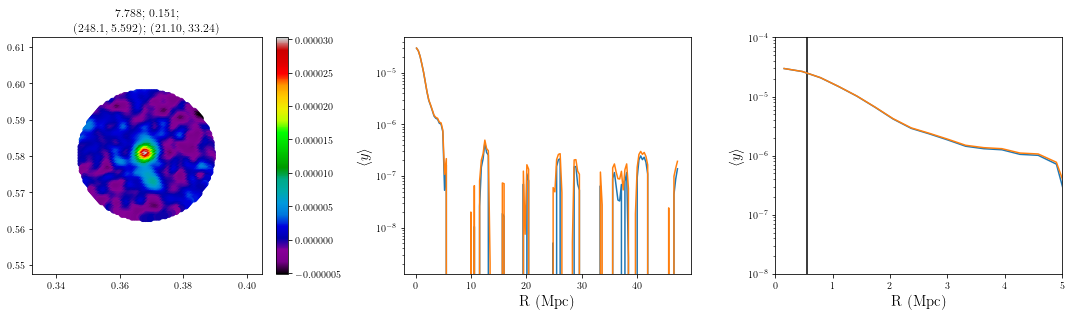

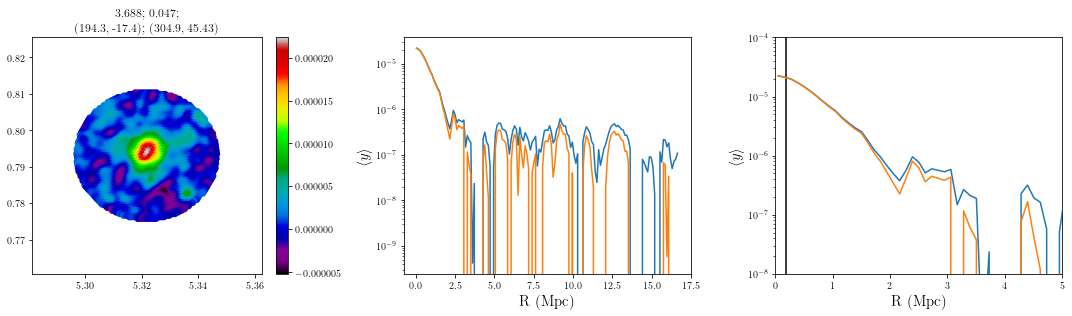

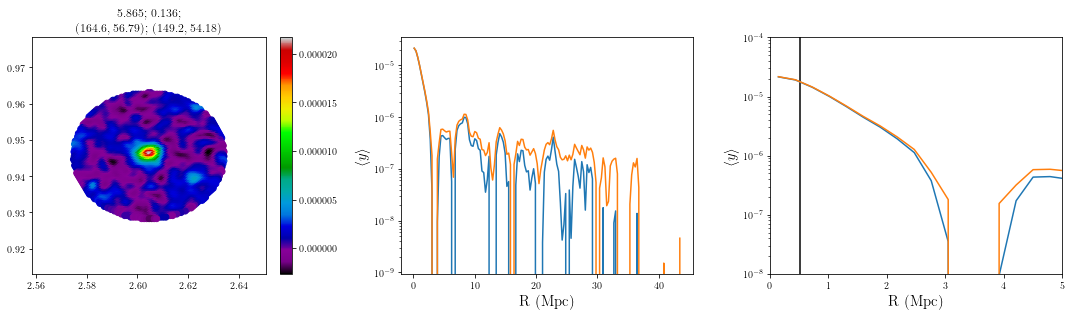

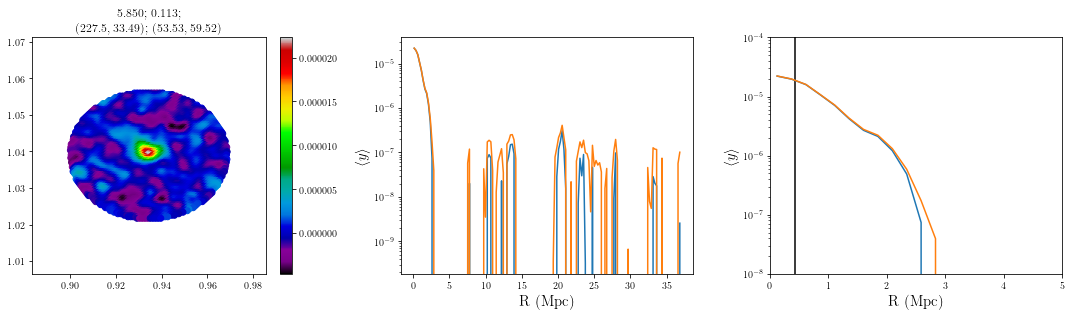

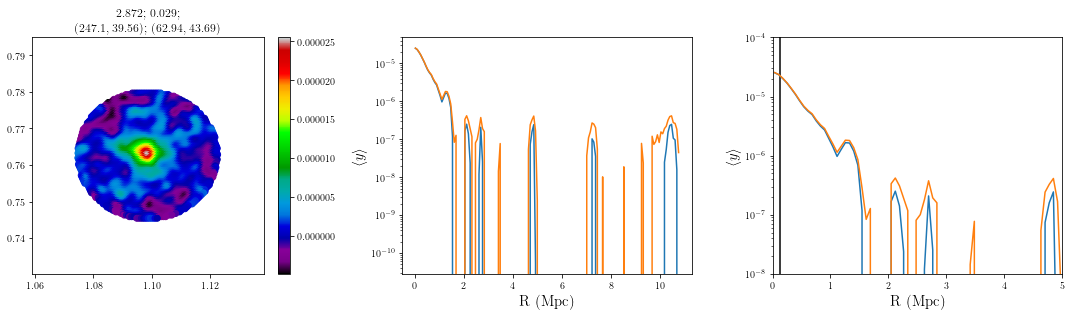

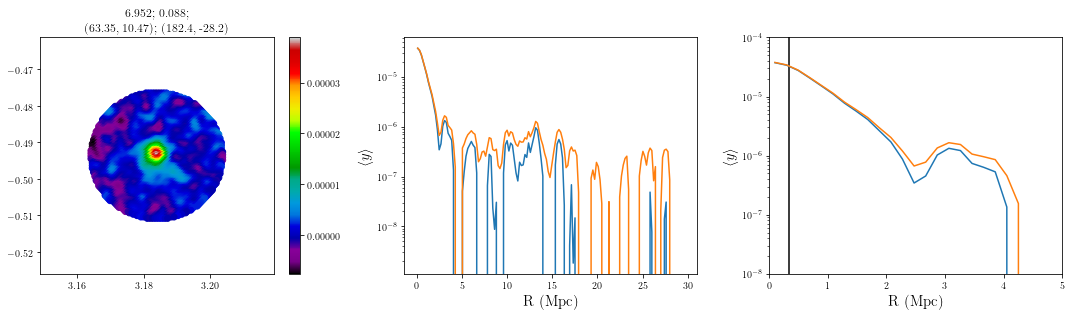

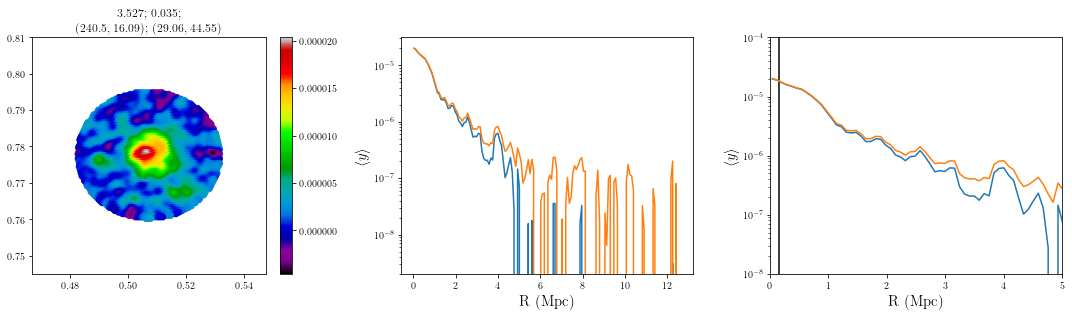

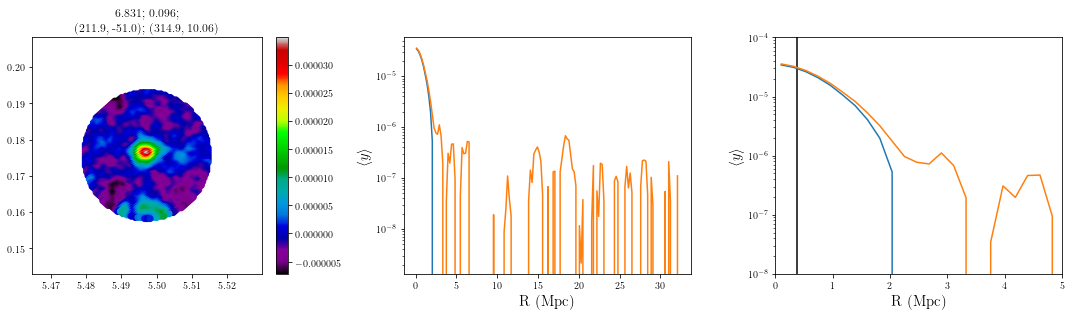

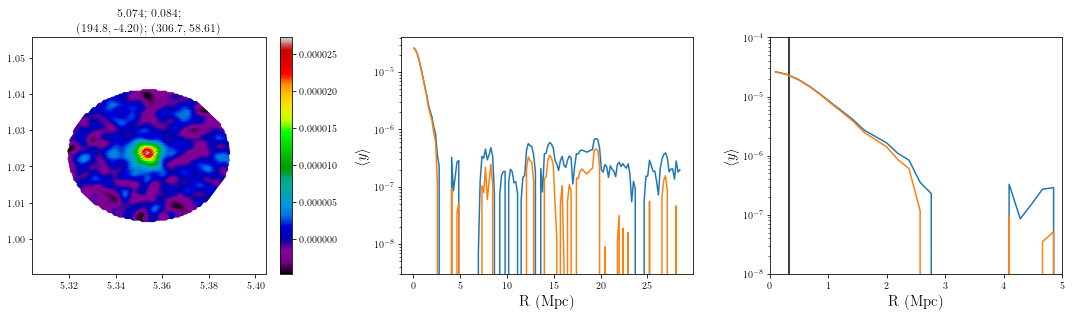

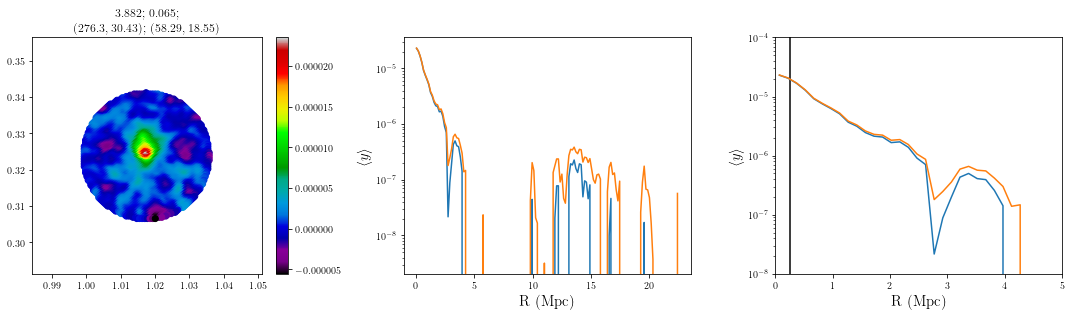

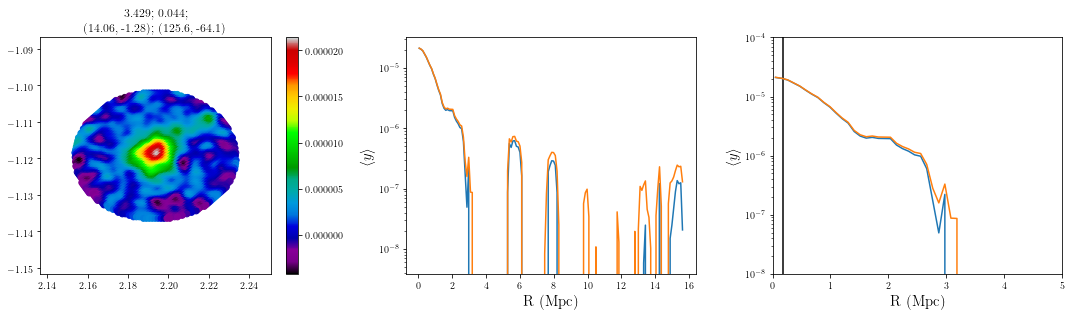

In [18]:
bin_edge = np.linspace(0.0, 300.0, num=151)
bin_min = bin_edge[:-1]
bin_max = bin_edge[1:]

for i in range(N):
    c1 = SkyCoord(phi_p[i]*u.rad, (np.pi/2 - theta_p[i])*u.rad, frame='icrs')
    c2 = SkyCoord(phi*u.rad, (np.pi/2 - theta)*u.rad, frame='icrs')
    sep = c1.separation(c2)
    ids2 = (sep.degree<1)
    
    mplot.figure(figsize=(15,4.5))
    mplot.subplot(131)
    mplot.scatter(phi[ids2], (np.pi/2 - theta[ids2]), c=sz_map[ids2], cmap='nipy_spectral')
    mplot.colorbar()
    mplot.title(str(mass_sel[i])[:5]+'; '+str(Z_sel[i])[:5]+';\n ('+str(RA_sel[i])[:5]+', '+str(DEC_sel[i])[:5]+')'
               +'; ('+str(LON_sel[i])[:5]+', '+str(LAT_sel[i])[:5]+')')
    
    # this is to get background
    ids = (sep.degree<5)
    ids_bg = (sep.degree>3)*(sep.degree<5)
    
    new_ra = phi[ids]*u.rad
    new_dec = (np.pi/2 - theta[ids])*u.rad
    new_sz = sz_map[ids]
    Y = []
    Yerr = []
    for j in range(150):
        c2 = SkyCoord(new_ra, new_dec, frame='icrs')
        sep = c1.separation(c2)
        mask = (np.array(sep.degree) >= bin_min[j]/60)*(np.array(sep.degree) < bin_max[j]/60)
        Y.append(np.median(new_sz[mask]))
        Yerr.append(np.std(new_sz[mask]))
    D = cosmo.comoving_distance(Z_sel[i]).value/(1+Z_sel[i])
    DD = D*(bin_min+bin_max)/2/60/180*np.pi
    bg = np.median(sz_map[ids_bg])

    beam = D*7.0/2/60/180*np.pi
    
    mplot.subplot(132)
    mplot.errorbar(DD, Y)
    mplot.errorbar(DD, Y-bg)
    mplot.yscale('log')
    mplot.xlabel('R (Mpc)', fontsize=15)
    mplot.ylabel('$\\langle y \\rangle$', fontsize=15)
    
    mplot.subplot(133)
    mplot.errorbar(DD, Y)
    mplot.errorbar(DD, Y-bg)
    mplot.plot([beam,beam],[1e-8,1e-4], color='k')

    mplot.yscale('log')
    mplot.xlim(0,5)
    mplot.ylim(1e-8,1e-4)
    mplot.xlabel('R (Mpc)', fontsize=15)
    mplot.ylabel('$\\langle y \\rangle$', fontsize=15)

    mplot.tight_layout()
    mplot.show()

### Here's to reproduce the paper's plot

In [16]:
## Find the cluster in the paper (Lon, Lat) = (75.7, 13.52)
lon = planck_data['GLON']
lat = planck_data['GLAT']
mask = (lon>75.6)*(lon<75.8)*(lat>13.5)*(lat<13.6)
print(planck_data['MSZ'][mask])
print(planck_data['SNR'][mask])

[8.735104]
[48.98511]


In [17]:
c = SkyCoord(ra=planck_data['RA'][mask]*u.degree, dec=planck_data['DEC'][mask]*u.degree, frame='icrs')
theta_p = (90.- np.array(c.galactic.b))/180*np.pi
phi_p = np.array(c.galactic.l)/180*np.pi

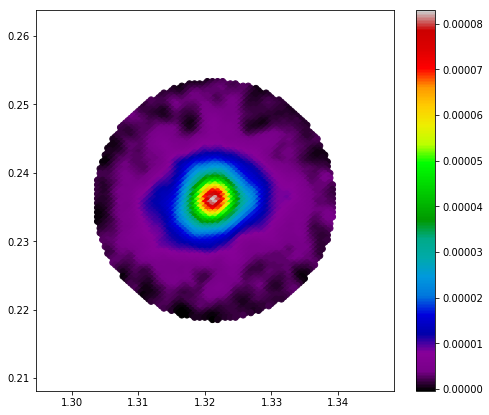

In [19]:
c1 = SkyCoord(phi_p*u.rad, (np.pi/2 - theta_p)*u.rad, frame='icrs')
c2 = SkyCoord(phi*u.rad, (np.pi/2 - theta)*u.rad, frame='icrs')
sep = c1.separation(c2)
ids2 = (sep.degree<1)

mplot.figure(figsize=(8,7))
mplot.scatter(phi[ids2]*u.rad, (np.pi/2 - theta[ids2])*u.rad, c=sz_map[ids2], cmap='nipy_spectral')
mplot.colorbar()
mplot.show()

ids = (sep.degree<5)


In [20]:
bin_edge = np.linspace(0.0, 300.0, num=151)
bin_min = bin_edge[:-1]
bin_max = bin_edge[1:]


new_ra = phi[ids]*u.rad
new_dec = (np.pi/2 - theta[ids])*u.rad
new_sz = sz_map[ids]
Y = []
Yerr = []
for i in range(150):
    c2 = SkyCoord(new_ra, new_dec, frame='icrs')
    sep = c1.separation(c2)
    mask = (np.array(sep.degree) >= bin_min[i]/60)*(np.array(sep.degree) < bin_max[i]/60)
    Y.append(np.mean(new_sz[mask]))
    Yerr.append(np.std(new_sz[mask]))
        

4
11
22
33
38
47
52
63
71
88
88
97
104
111
126
138
144
148
150
164
174
193
189
200
206
214
225
240
246
246
257
264
285
283
298
307
302
314
331
348
342
347
361
368
384
388
404
400
404
418
440
447
440
456
460
469
489
492
503
499
509
517
545
542
557
549
562
567
597
601
593
611
605
627
634
656
653
653
661
668
706
693
714
695
713
725
742
754
758
760
746
782
796
812
792
811
820
816
846
868
852
856
859
878
902
918
900
905
919
926
956
963
945
965
969
974
1004
1017
997
1008
1018
1048
1038
1065
1059
1054
1067
1081
1111
1103
1123
1093
1130
1136
1158
1160
1157
1160
1171
1182
1206
1225
1201
1209
1231
1216
1280
1256
1273
1236


Text(0, 0.5, '$\\langle y \\rangle$')

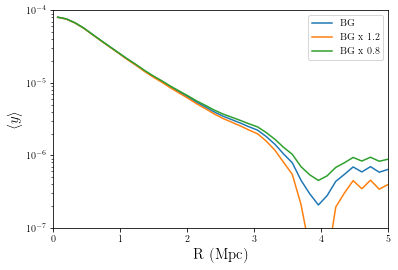

In [65]:
D = cosmo.comoving_distance(0.0557).value/(1+0.0557)
DD = D*(bin_min+bin_max)/2/60/180*np.pi
X = Y*((DD>10)*(DD<15))
X = X[X!=0]
bg = np.mean(X)
mplot.errorbar(D*(bin_min+bin_max)/2/60/180*np.pi, Y-bg, label='BG')
mplot.errorbar(D*(bin_min+bin_max)/2/60/180*np.pi, Y-bg*1.2, label='BG x 1.2')
mplot.errorbar(D*(bin_min+bin_max)/2/60/180*np.pi, Y-bg*0.8, label='BG x 0.8')
mplot.legend()
# mplot.xscale('log')
mplot.yscale('log')
mplot.xlim(0,5)
mplot.ylim(1e-7,1e-4)
mplot.xlabel('R (Mpc)', fontsize=15)
mplot.ylabel('$\\langle y \\rangle$', fontsize=15)

Text(0, 0.5, '$\\langle y \\rangle$')

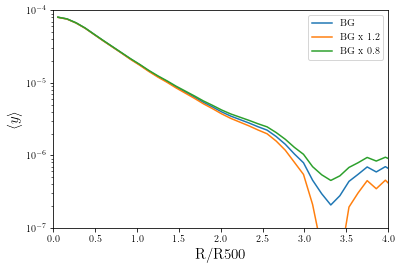

In [66]:
D = cosmo.comoving_distance(0.0557).value/(1+0.0557)
DD = (bin_min+bin_max)/2/18.4
mplot.errorbar(DD, Y-bg, label='BG')
mplot.errorbar(DD, Y-bg*1.2, label='BG x 1.2')
mplot.errorbar(DD, Y-bg*0.8, label='BG x 0.8')
mplot.legend()
# mplot.xscale('log')
mplot.yscale('log')
mplot.xlim(0,4)
mplot.ylim(1e-7,1e-4)
mplot.xlabel('R/R500', fontsize=15)
mplot.ylabel('$\\langle y \\rangle$', fontsize=15)

In [ ]:
    X = Y*((DD>10)*(DD<15))
    X = X[X!=0]